# End-to-End Example

We will be looking at Radio Data System (RDS), which is a communications protocol for embedding small amounts of information in FM radio broadcasts, such as station and song name. We will have to demodulate FM, frequency shift, filter, decimate, resample, synchronize, decode, and parse the bytes. An example IQ file is provided for testing purposes or if you don’t have an SDR handy.

## Introduction to FM Radio and RDS

To understand RDS we must first review FM radio broadcasts and how their signals are structured. You are probably familiar with the audio portion of FM signals, which are simply audio signals frequency modulated and transmitted at center frequencies corresponding to the station’s name, e.g., “WPGC 95.5 FM” is centered at exactly 95.5 MHz. In addition to the audio portion, each FM broadcast contains some other components that are frequency modulated along with the audio. Instead of just Googling the signal structure, let’s take a look at the power spectral density (PSD) of an example FM signal, after the FM demodulation. We only view the positive portion because the output of FM demodulation is a real signal, even though the input was complex (we will view the code to perform this demodulation shortly).

The spectrum would looks like:

![Alt text](https://pysdr.org/_images/fm_psd.svg)

![Alt text](https://pysdr.org/_images/fm_before_demod.svg)

Carson’s bandwidth rule applied to FM tells us that FM stations occupy roughly 250 kHz of spectrum, which is why we usually sample at 250 kHz (recall that when using quadrature/IQ sampling, your received bandwidth equals your sampling rate).

We come to RDS, which is the focus of the rest of this chapter. As we can see in our first PSD, RDS is roughly 4 kHz in bandwidth (before it gets FM modulated), and sits in between the stereo audio and DirectBand signal. It is a low data rate digital communications protocol that allows FM stations to include station identification, program information, time, and other miscellaneous information alongside the audio. The RDS standard is published as IEC standard 62106 and can be found here.

## The RDS Signal

### Transmit Side

The RDS information to be transmitted by the FM station (e.g., track name, etc.) is __encoded into sets of 8 bytes.__ Each set of 8 bytes, which corresponds to 64 bits, is combined with 40 “check bits” to make a single “group”. __These 104 bits are transmitted together, although there is no gap of time between groups,__ so from the receiver’s perspective it receives these bits nonstop and must determine the boundary between the groups of 104 bits. We will see more details on the encoding and message structure once we dive into the receive side.

To transmit these bits wirelessly, __RDS uses BPSK__, which as we learned in the Digital Modulation chapter is a simple digital modulation scheme used to map 1’s and 0’s to the phase of a carrier. Like many BPSK-based protocols, __RDS uses differential coding__, which simply means the 1’s and 0’s of data are encoded in changes of 1’s and 0’s instead, which lets you no longer care whether you are 180 degrees out of phase (more on this later). __The BPSK symbols are transmitted at 1187.5 symbols per second, and because BPSK carries one bit per symbol, that means RDS has a raw data rate of roughly 1.2 kbps__ (including overhead). __RDS does not contain any channel coding__ (a.k.a. forward error correction), although the __data packets do contain a cyclic redundancy check (CRC)__ to know when an error occurred.

The final BPSK signal is then frequency shifted up to 57 kHz and added to all the other components of the FM signal, before being FM modulated and transmitted over the air at the station’s frequency. FM radio signals are transmitted at an extremely high power compared to most other wireless communications, up to 80 kW! This is why many SDR users have an FM-reject filter (i.e., a band-stop filter) in-line with their antenna; so FM does not add interference to what they are trying to receive.

### Receive Side

In order to demodulate and decode RDS, we will perform the following steps:

1. Receive an FM radio signal centered at the station’s frequency (or read in an IQ recording), usually at a sample rate of 250 kHz

2. Demodulate the FM using what is called “quadrature demodulation”

3. Frequency shift by 57 kHz so the RDS signal is centered at 0 Hz

4. Low-pass filter, to filter out everything besides RDS (also acts as matched filter)

5. Decimate by 10 so that we can work at a lower sample rate, since we filtered out the higher frequencies anyway

6. Resample to 19 kHz which will give us an integer number of samples per symbol

7. Symbol-level time synchronization, using Mueller and Muller in this example

8. Fine frequency synchronization using a Costas loop

9. Demodulate the BPSK to 1’s and 0’s

10. Differential decoding, to undo the differential encoding that was applied

11. Decoding of the 1’s and 0’s into groups of bytes

12. Parsing of the groups of bytes into our final output


While this may seem like a lot of steps, RDS is actually one of the simplest wireless digital communications protocols out there. A modern wireless protocol like WiFi or 5G requires a whole textbook to cover just the high-level PHY/MAC layer information.

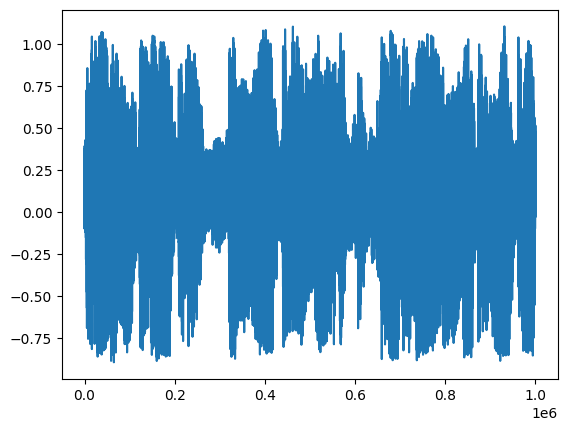

In [1]:
import numpy as np
from scipy.signal import resample_poly, firwin, bilinear, lfilter
import matplotlib.pyplot as plt

# Read in signal
x = np.fromfile("fm_rds_250k_1Msamples.iq", np.complex64)
sample_rate = 250e3
fc = 99.5e6

# Quadrature Demod
x = 0.5 * np.angle(x[0:-1] * np.conj(x[1:])) # see https://wiki.gnuradio.org/index.php/Quadrature_Demod
plt.plot(x)

As discussed at the beginning of this chapter, several individual signals are combined in frequency and FM modulated to create what is actually transmitted through the air. So the first step is to undo that FM modulation. Another way to think about it is the information is stored in the frequency variation of the signal we receive, and we want to demodulate it so the information is now in the amplitude not frequency. Note that the output of this demodulation is a real signal, even though we fed in a complex signal.

What this single line of Python is doing, is first calculating the product of our signal with a delayed and conjugated version of our signal. Next, it finds the phase of each sample in that result, which is the moment at which it goes from complex to real. To prove to ourselves that this gives us the information contained in the frequency variations, consider a tone at frequency f with some arbitrary phase \phi, which we can represent as e^{j2 \pi (f t + \phi)}. When dealing in discrete time, which uses an integer n instead of t, this becomes e^{j2 \pi (f n + \phi)}. The conjugated and delayed version is e^{-j2 \pi (f (n-1) + \phi)}. Multiplying these two together leads to e^{j2 \pi f}, which is great because \phi is gone, and when we calculate the phase of that expression we are left with just f.

One convenient side effect of FM modulation is that amplitude variations of the received signal does not actually change the volume of the audio, unlike AM radio.

/home/codespace/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


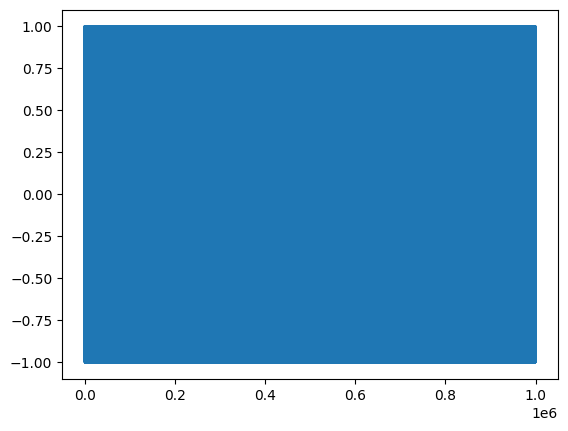

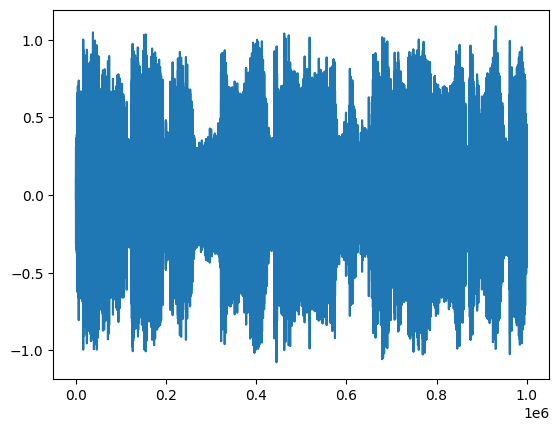

In [2]:
# Frequency Shift
N = len(x)
f_o = -57e3 # amount we need to shift by
t = np.arange(N)/sample_rate # time vector
plt.figure()
plt.plot(np.exp(2j*np.pi*f_o*t))
x = x * np.exp(2j*np.pi*f_o*t) # down shift
plt.figure()
plt.plot(x)

Next we frequency shift down by 57 kHz, using the e^{j2 \pi f_ot} trick we learned in the Synchronization chapter where f_o is the frequency shift in Hz and t is just a time vector, the fact it starts at 0 isn’t important, what matters is that it uses the right sample period (which is inverse of sample rate). As an aside, because it’s a real signal being fed in, it doesn’t actually matter if you use a -57 or +57 kHz because the negative frequencies match the positive, so either way we are going to get our RDS shifted to 0 Hz.

In [3]:
# Low-Pass Filter to isolate RDS
taps = firwin(numtaps=101, cutoff=7.5e3, fs=sample_rate)
x = np.convolve(x, taps, 'valid')

Now we must filter out everything besides RDS. Since we have RDS centered at 0 Hz, that means a low-pass filter is the one we want. We use firwin() to design an FIR filter (i.e., find the taps), which just needs to know how many taps we want the filter to be, and the cutoff frequency. The sample rate must also be provided or else the cutoff frequency doesn’t make sense to firwin. The result is a symmetric low-pass filter, so we know the taps are going to be real numbers, and we can apply the filter to our signal using a convolution. We choose 'valid' to get rid of the edge effects of doing convolution, although in this case it doesn’t really matter because we are feeding in such a long signal that a few weird samples on either edge isn’t going to throw anything off.

In [4]:
# Decimeate by 10
# Decimate by 10, now that we filtered and there wont be aliasing
x = x[::10]
sample_rate /= 10 # New rate is now 25e3

Any time you filter down to a small fraction of your bandwidth (e.g., we started with 125 kHz of real bandwidth and saved only 7.5 kHz of that), it makes sense to decimate. Recall the beginning of the IQ Sampling chapter where we learned about the Nyquist Rate and being able to fully store band-limited information as long as we sampled at twice the highest frequency. Well now that we used our low-pass filter, our highest frequency is about 7.5 kHz, so we only need a sample rate of 15 kHz. Just to be safe we’ll add some margin and use a new sample rate of 25 kHz (this ends up working well mathematically later on).

We perform the decimation by simply throwing out 9 out of every 10 samples, since we previously were at a sample rate of 250 kHz and we want it to now be at 25 kHz. This might seem confusing at first, because throwing out 90% of the samples feels like you are throwing out information, but if you review the IQ Sampling chapter you will see why we are not actually losing anything, because we filtered properly (which acted as our anti-aliasing filter) and reduced our maximum frequency and thus signal bandwidth.

In [5]:
# Resample to 19kHz
x = resample_poly(x, 19, 25) # up, down
sample_rate = 19e3

In the Pulse Shaping chapter we solidified the concept of “samples per symbol”, and learned the convenience of having an integer number of samples per symbol (a fractional value is valid, just not convenient). As mentioned earlier, RDS uses BPSK transmitting 1187.5 symbols per second. If we continue to use our signal as-is, sampled at 25 kHz, we’ll have 21.052631579 samples per symbol (pause and think about the math if that doesn’t make sense). So what we really want is a sample rate that is an integer multiple of 1187.5 Hz, but we can’t go too low or we won’t be able to “store” our full signal’s bandwidth. In the previous subsection we talked about how we need a sample rate of 15 kHz or higher, and we chose 25 kHz just to give us some margin.

Finding the best sample rate to resample to comes down to how many samples per symbol we want, and we can work backwards. Hypothetically, let us consider targeting 10 samples per symbol. The RDS symbol rate of 1187.5 multiplied by 10 would give us a sample rate of 11.875 kHz, which unfortunately is not high enough for Nyquist. How about 13 samples per symbol? 1187.5 multiplied by 13 gives us 15437.5 Hz, which is above 15 kHz, but quite the uneven number. How about the next power of 2, so 16 samples per symbol? 1187.5 multiplied by 16 is exactly 19 kHz! The even number is less of a coincidence and more of a protocol design choice.

To resample from 25 kHz to 19 kHz, we use resample_poly() which upsamples by an integer value, filters, then downsamples by an integer value. This is convenient because instead of entering in 25000 and 19000 we can use 25 and 19. If we had used 13 samples per symbol by using a sample rate of 15437.5 Hz, we wouldn’t be able to use resample_poly() and the resampling process would be much more complicated.

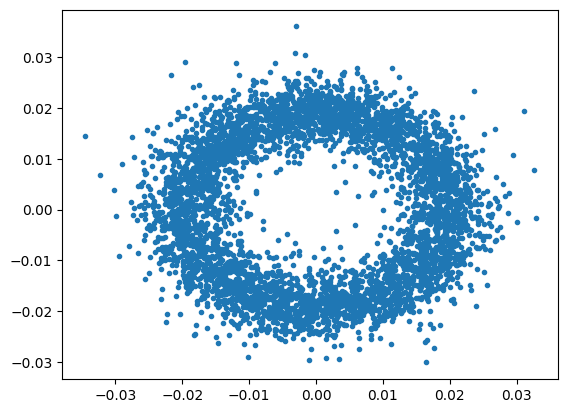

In [6]:
# Time Synchronization (Symbol-Level)
# Symbol sync, using what we did in sync chapter
samples = x # for the sake of matching the sync chapter
samples_interpolated = resample_poly(samples, 32, 1) # we'll use 32 as the interpolation factor, arbitrarily chosen, seems to work better than 16
sps = 16
mu = 0.01 # initial estimate of phase of sample
out = np.zeros(len(samples) + 10, dtype=np.complex64)
out_rail = np.zeros(len(samples) + 10, dtype=np.complex64) # stores values, each iteration we need the previous 2 values plus current value
i_in = 0 # input samples index
i_out = 2 # output index (let first two outputs be 0)
while i_out < len(samples) and i_in+32 < len(samples):
    out[i_out] = samples_interpolated[i_in*32 + int(mu*32)] # grab what we think is the "best" sample
    out_rail[i_out] = int(np.real(out[i_out]) > 0) + 1j*int(np.imag(out[i_out]) > 0)
    x = (out_rail[i_out] - out_rail[i_out-2]) * np.conj(out[i_out-1])
    y = (out[i_out] - out[i_out-2]) * np.conj(out_rail[i_out-1])
    mm_val = np.real(y - x)
    mu += sps + 0.01*mm_val
    i_in += int(np.floor(mu)) # round down to nearest int since we are using it as an index
    mu = mu - np.floor(mu) # remove the integer part of mu
    i_out += 1 # increment output index
x = out[2:i_out] # remove the first two, and anything after i_out (that was never filled out)

plt.plot(np.real(x), np.imag(x), '.')